# 📦 Import required libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
import matplotlib.pyplot as plt
import os
import json

print("Modules loaded")

Modules loaded


# Set parameters

In [2]:
dataset_folder = os.path.abspath(os.path.join(".", "..", "..", "..", "data_acquisition", "image_dataset", "dataset", "final_pokemon_dataset"))
img_height, img_width = 224, 224
batch_size = 8
seed = 123

print("Dataset folder:", dataset_folder)

Dataset folder: c:\Users\dylan\Documents\Dev\PokemonGOBattleAssistant\data_acquisition\image_dataset\dataset\final_pokemon_dataset


# Load dataset

In [3]:
train_ds = image_dataset_from_directory(
    os.path.join(dataset_folder, "train"),
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds_raw = image_dataset_from_directory(
    os.path.join(dataset_folder, "test"),
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Split validation
val_batches = tf.data.experimental.cardinality(val_ds_raw)
val_size = val_batches // 5  # 20%
val_ds = val_ds_raw.take(val_size)
test_ds = val_ds_raw.skip(val_size)

class_names = train_ds.class_names
print("Classes:", class_names)

Found 16773 files belonging to 727 classes.
Found 4571 files belonging to 727 classes.
Classes: ['Abomasnow', 'Absol', 'Accelgor', 'Aerodactyl', 'Aggron', 'Aipom', 'Alakazam', 'Alomomola', 'Altaria', 'Amaura', 'Ambipom', 'Amoonguss', 'Ampharos', 'Annihilape', 'Anorith', 'Appletun', 'Araquanid', 'Arbok', 'Arboliva', 'Arcanine', 'Arcanine (Hisuian)', 'Archen', 'Archeops', 'Arctibax', 'Ariados', 'Armaldo', 'Armarouge', 'Aromatisse', 'Aron', 'Articuno', 'Articuno (Galarian)', 'Audino', 'Aurorus', 'Avalugg', 'Avalugg (Hisuian)', 'Axew', 'Azelf', 'Azumarill', 'Banette', 'Barbaracle', 'Basculin', 'Bastiodon', 'Baxcalibur', 'Bayleef', 'Beartic', 'Beautifly', 'Beedrill', 'Beheeyem', 'Bellibolt', 'Bellossom', 'Bergmite', 'Bewear', 'Bibarel', 'Bisharp', 'Blastoise', 'Blaziken', 'Blissey', 'Boldore', 'Boltund', 'Bombirdier', 'Bonsly', 'Bouffalant', 'Braixen', 'Braviary', 'Braviary (Hisuian)', 'Breloom', 'Brionne', 'Bronzong', 'Bruxish', 'Bulbasaur', 'Buneary', 'Butterfree', 'Buzzwole', 'Cacturne',

# Preview dataset images

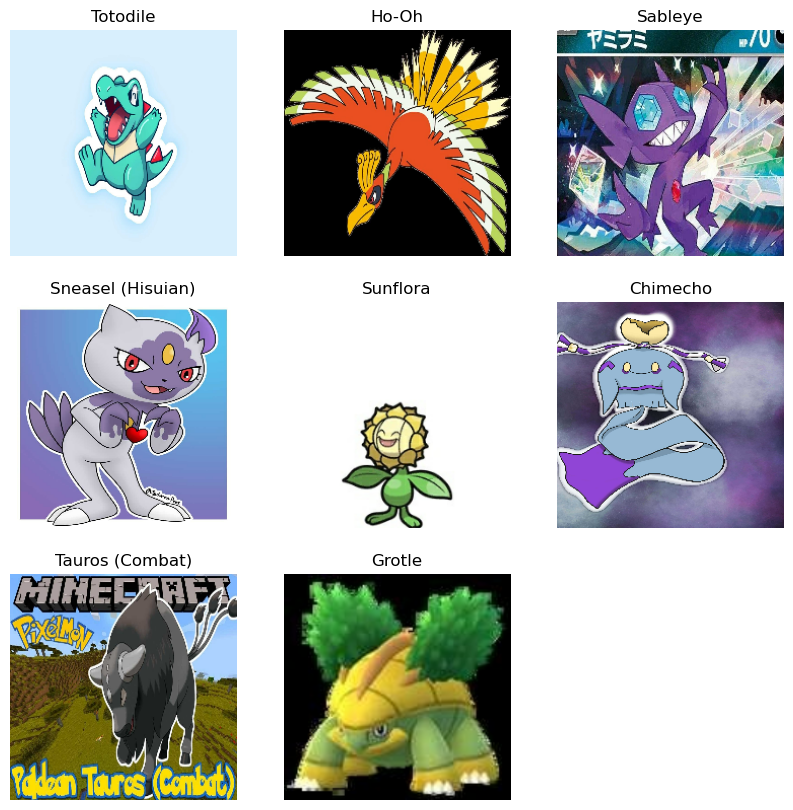

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    num_images = min(9, images.shape[0])  # Adjust to the number of images in the batch
    for i in range(num_images):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

# Prefetch & cache datasets

In [5]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Data Augmentation

In [6]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.4),
    layers.RandomZoom(0.3),
    layers.RandomContrast(0.3),
    layers.RandomBrightness(0.3)
])

# Transfer Learning - EfficientNetB0

In [7]:
base_model = EfficientNetB0(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False

# Build the model

In [8]:
inputs = layers.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)
model = models.Model(inputs, outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 727)            │        93,783 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,307,322 (16.43 MB)

 Trainable params: 257,751 (1006.84 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

# Compile the model

In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define Callbacks

In [10]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

class SaveEveryN(tf.keras.callbacks.Callback):
    def __init__(self, n, folder):
        super().__init__()
        self.n = n
        self.folder = folder

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.n == 0:
            filename = os.path.join(self.folder, f"checkpoint_epoch_{epoch+1:02d}.keras")
            self.model.save(filename, save_format='keras')
            print(f"💾 Saved checkpoint: {filename}")

save_every_10_cb = SaveEveryN(10, checkpoint_dir)

# Train model with frozen base

In [11]:
initial_epochs = 40
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=initial_epochs,
    callbacks=[early_stop, save_every_10_cb]
)

Epoch 1/40
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 5658s 3s/step - accuracy: 0.0027 - loss: 6.5784 - val_accuracy: 0.0241 - val_loss: 6.2874
Epoch 2/40
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 1025s 489ms/step - accuracy: 0.0202 - loss: 6.1738 - val_accuracy: 0.0899 - val_loss: 5.7052
Epoch 3/40
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 980s 459ms/step - accuracy: 0.0478 - loss: 5.6935 - val_accuracy: 0.1645 - val_loss: 5.1870
Epoch 4/40
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 779s 372ms/step - accuracy: 0.0719 - loss: 5.3342 - val_accuracy: 0.2270 - val_loss: 4.7691
Epoch 5/40
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 768s 366ms/step - accuracy: 0.1051 - loss: 5.0343 - val_accuracy: 0.2708 - val_loss: 4.4412
Epoch 6/40
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 1058s 504ms/step - accuracy: 0.1172 - loss: 4.7592 - val_accuracy: 0.3224 - val_loss: 4.1523
Epoch 7/40
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 1033s 493ms/step - accuracy: 0.1455 - loss: 4.5445 - val_accuracy: 0.3509 - val_loss: 3.9141
Epoch 8/40
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 839s 400ms/step - a

💾 Saved checkpoint: checkpoints\checkpoint_epoch_10.keras
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 826s 394ms/step - accuracy: 0.1994 - loss: 4.0453 - val_accuracy: 0.4112 - val_loss: 3.3901
Epoch 11/40
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 799s 381ms/step - accuracy: 0.2204 - loss: 3.9052 - val_accuracy: 0.4320 - val_loss: 3.2682
Epoch 12/40
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 955s 455ms/step - accuracy: 0.2381 - loss: 3.7884 - val_accuracy: 0.4353 - val_loss: 3.1610
Epoch 13/40
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 872s 416ms/step - accuracy: 0.2557 - loss: 3.6824 - val_accuracy: 0.4539 - val_loss: 3.0550
Epoch 14/40
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 7792s 4s/step - accuracy: 0.2585 - loss: 3.6095 - val_accuracy: 0.4529 - val_loss: 2.9778
Epoch 15/40
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 590s 281ms/step - accuracy: 0.2795 - loss: 3.5324 - val_accuracy: 0.4814 - val_loss: 2.9026
Epoch 16/40
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 665s 317ms/step - accuracy: 0.2992 - loss: 3.4044 - val_accuracy: 0.4759 - val_loss: 2.8081
Epoch 17/40

💾 Saved checkpoint: checkpoints\checkpoint_epoch_20.keras
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 662s 315ms/step - accuracy: 0.3353 - loss: 3.1736 - val_accuracy: 0.4934 - val_loss: 2.6173
Epoch 21/40
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 635s 303ms/step - accuracy: 0.3304 - loss: 3.1496 - val_accuracy: 0.5088 - val_loss: 2.5456
Epoch 22/40
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 634s 302ms/step - accuracy: 0.3508 - loss: 3.1020 - val_accuracy: 0.5055 - val_loss: 2.5328
Epoch 23/40
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 639s 305ms/step - accuracy: 0.3559 - loss: 3.0382 - val_accuracy: 0.5110 - val_loss: 2.4894
Epoch 24/40
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 635s 303ms/step - accuracy: 0.3646 - loss: 2.9943 - val_accuracy: 0.5164 - val_loss: 2.4710
Epoch 25/40
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 646s 308ms/step - accuracy: 0.3661 - loss: 2.9710 - val_accuracy: 0.5252 - val_loss: 2.4189
Epoch 26/40
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 644s 307ms/step - accuracy: 0.3791 - loss: 2.9203 - val_accuracy: 0.5351 - val_loss: 2.3935
Epoch 27/

💾 Saved checkpoint: checkpoints\checkpoint_epoch_30.keras
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 725s 346ms/step - accuracy: 0.3945 - loss: 2.8231 - val_accuracy: 0.5263 - val_loss: 2.3140
Epoch 31/40
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 710s 338ms/step - accuracy: 0.3995 - loss: 2.7791 - val_accuracy: 0.5384 - val_loss: 2.2889
Epoch 32/40
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 725s 346ms/step - accuracy: 0.4087 - loss: 2.7645 - val_accuracy: 0.5417 - val_loss: 2.2879
Epoch 33/40
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 754s 360ms/step - accuracy: 0.4197 - loss: 2.7383 - val_accuracy: 0.5493 - val_loss: 2.2589
Epoch 34/40
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 748s 357ms/step - accuracy: 0.4114 - loss: 2.7219 - val_accuracy: 0.5461 - val_loss: 2.2317
Epoch 35/40
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 753s 359ms/step - accuracy: 0.4149 - loss: 2.7270 - val_accuracy: 0.5482 - val_loss: 2.2206
Epoch 36/40
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 753s 359ms/step - accuracy: 0.4165 - loss: 2.6976 - val_accuracy: 0.5461 - val_loss: 2.2161
Epoch 37/

💾 Saved checkpoint: checkpoints\checkpoint_epoch_40.keras
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 808s 385ms/step - accuracy: 0.4332 - loss: 2.6074 - val_accuracy: 0.5581 - val_loss: 2.1506


# Unfreeze base model and fine-tune

In [12]:
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1] + 1,
    callbacks=[early_stop, save_every_10_cb]
)

Epoch 41/50
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 3428s 2s/step - accuracy: 0.1658 - loss: 4.4538 - val_accuracy: 0.4375 - val_loss: 3.7984
Epoch 42/50
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 3349s 2s/step - accuracy: 0.2857 - loss: 3.4874 - val_accuracy: 0.5329 - val_loss: 3.3877
Epoch 43/50
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 3568s 2s/step - accuracy: 0.3245 - loss: 3.1543 - val_accuracy: 0.5515 - val_loss: 4.7160
Epoch 44/50
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 3497s 2s/step - accuracy: 0.3649 - loss: 2.9110 - val_accuracy: 0.5855 - val_loss: 3.8007
Epoch 45/50
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 3243s 2s/step - accuracy: 0.3900 - loss: 2.7671 - val_accuracy: 0.6140 - val_loss: 4.2103
Epoch 46/50
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 3126s 1s/step - accuracy: 0.4142 - loss: 2.6254 - val_accuracy: 0.6195 - val_loss: 3.3448
Epoch 47/50
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 3249s 2s/step - accuracy: 0.4287 - loss: 2.5564 - val_accuracy: 0.6414 - val_loss: 3.0771
Epoch 48/50
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 3661s 2s/step - accuracy: 

💾 Saved checkpoint: checkpoints\checkpoint_epoch_50.keras
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 4481s 2s/step - accuracy: 0.4609 - loss: 2.3262 - val_accuracy: 0.6678 - val_loss: 3.1428


# Plot accuracy over epochs

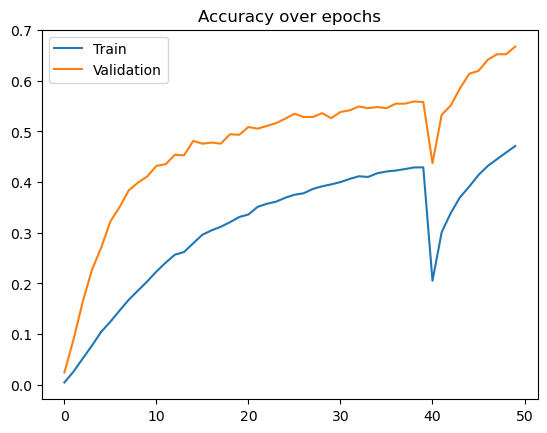

In [13]:
plot_data = {
    "accuracy": history.history['accuracy'] + history_fine.history['accuracy'],
    "val_accuracy": history.history['val_accuracy'] + history_fine.history['val_accuracy']
}

with open("plot_data.json", "w") as f:
    json.dump(plot_data, f)

plt.plot(plot_data['accuracy'], label='Train')
plt.plot(plot_data['val_accuracy'], label='Validation')
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

# Save final model

In [ ]:
final_model_path = "pokemon_final_model_EfficientNetB0_v2.keras"
model.save(final_model_path, save_format='keras')
print(f"Final model saved to: {final_model_path}")

Final model saved to: pokemon_final_model_v2.keras


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 8 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

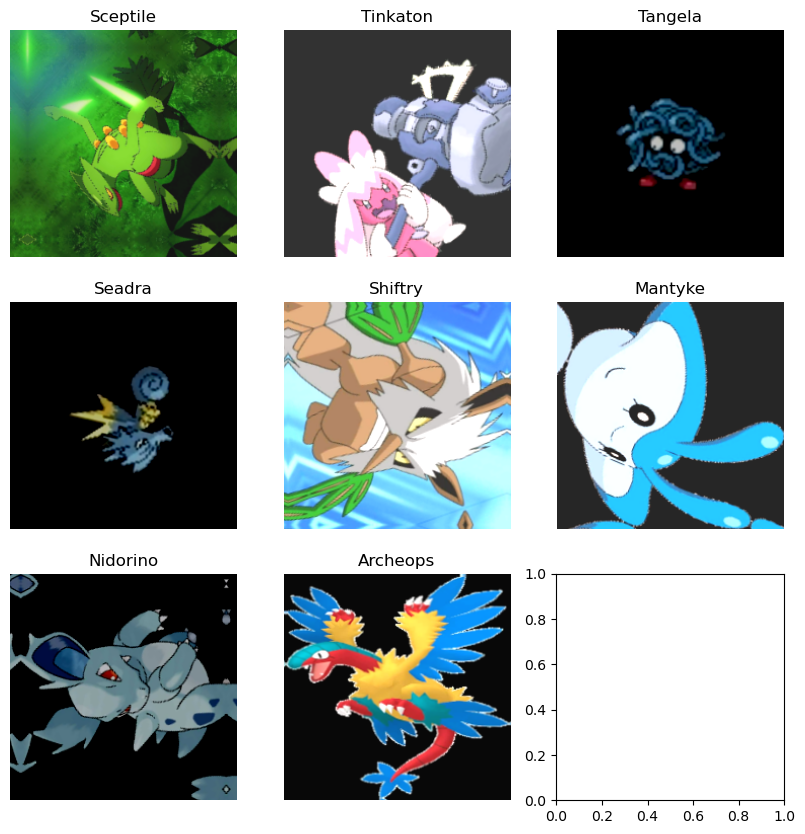

In [15]:
# Visualize data augmentation
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    augmented_images = data_augmentation(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

# Confusion matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


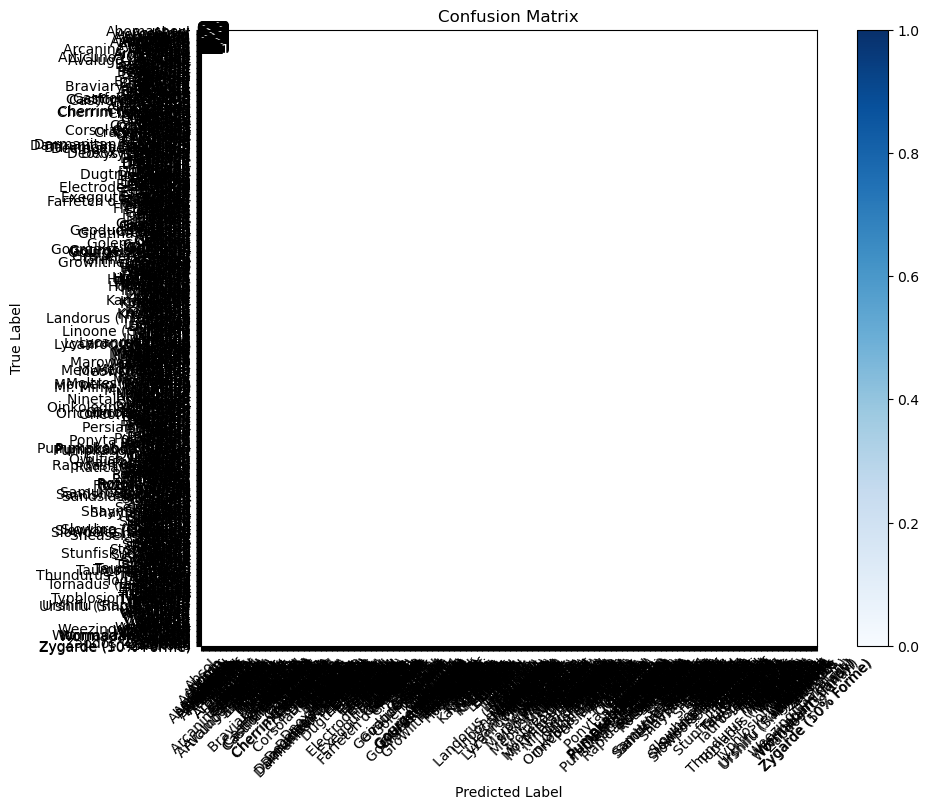

In [22]:
import itertools
from sklearn.metrics import confusion_matrix

# Select 20 random samples from the test dataset
random_samples = test_ds.unbatch().shuffle(1000).take(20)
true_labels = []
predicted_labels = []

for images, labels in random_samples:
    predictions = model.predict(tf.expand_dims(images, axis=0))
    predicted_labels.append(tf.argmax(predictions[0]).numpy())
    true_labels.append(labels.numpy())

# Create confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
classes = class_names

plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add class labels to the axes
tick_marks = range(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add text annotations
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]}", horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Prediction using loaded_model

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


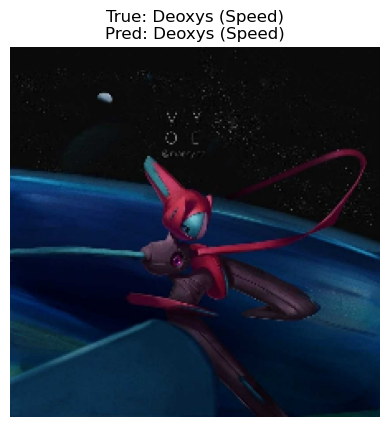

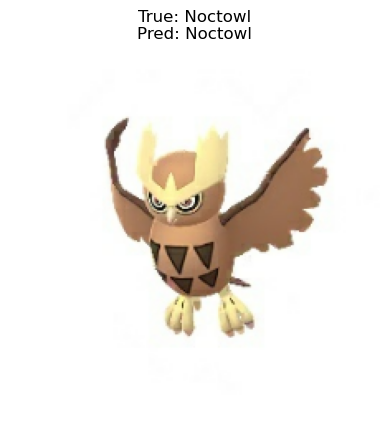

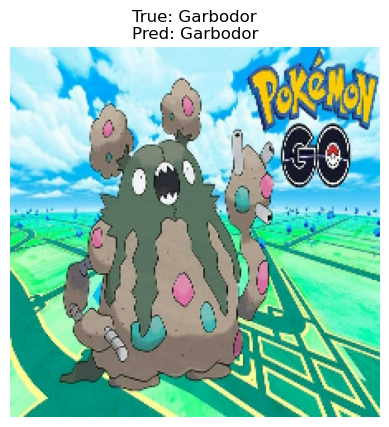

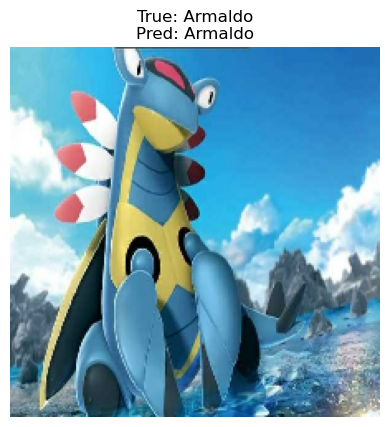

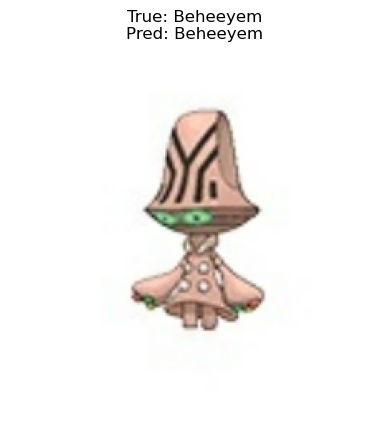

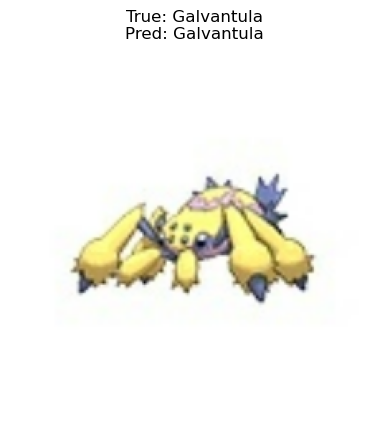

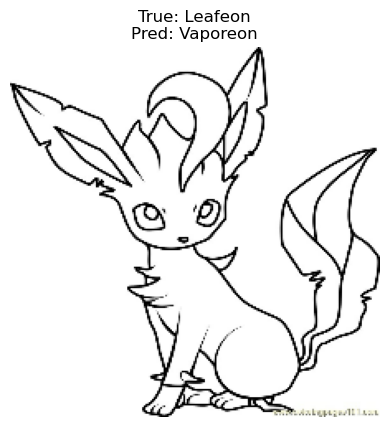

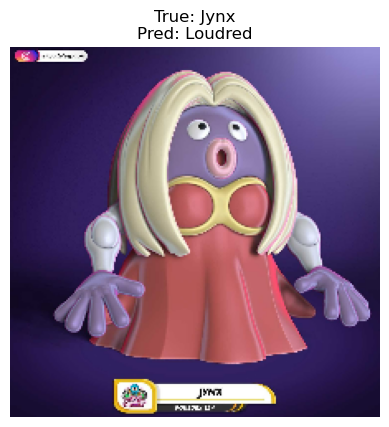

In [ ]:
loaded_model = tf.keras.models.load_model("pokemon_final_model_EfficientNetB0_v2.keras", compile=False)
loaded_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

# Select a random sample from the test dataset
for images, labels in test_ds.take(1):
    predictions = loaded_model.predict(images)
    for i in range(len(images)):
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[tf.argmax(predictions[i]).numpy()]}")
        plt.axis("off")
        plt.show()